In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks')

# New section

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from TrajectoryObject import TrajectoryObj
from FileIO import write_trajectory, read_trajectory, read_mosaic, read_localization, read_andi2_trajectory_label
from andi_datasets.models_phenom import models_phenom
from andi_datasets.datasets_phenom import datasets_phenom
from andi_datasets.utils_trajectories import plot_trajs
from andi_datasets.utils_challenge import label_continuous_to_list

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2024-03-17 22:44:54.246309: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [227]:
TIME_INTERVAL = 1
NB_INPUT_FEATURES = 5
NB_LABEL_FEATURES = 1
WINDOW_WIDTH=5
SHUFFLE=True
MAX_EPOCHS = 3000
BATCH_SIZE=256
PATIENCE=100

In [228]:
N=1
T=2000
L = 1.5*128

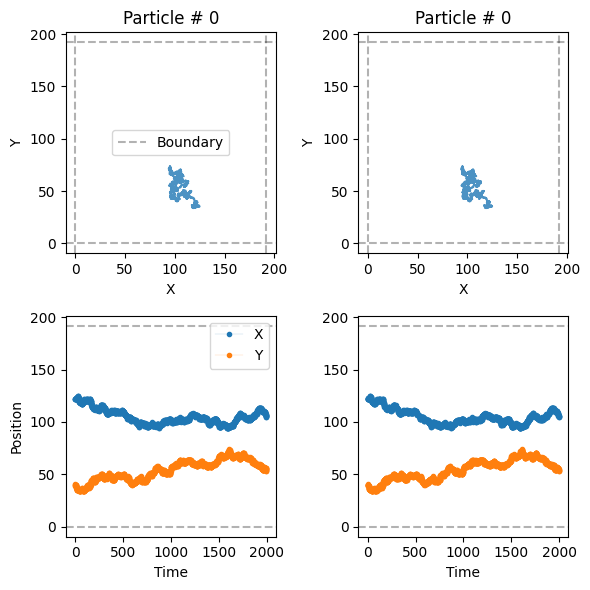

In [229]:
trajs_model, labels_model = models_phenom().multi_state(N=N,
                                                        L=L,
                                                        T=T,
                                                        alphas=[0.85, 1.15],  # Fixed alpha for each state
                                                        Ds=[[0.1, 0.0], [0.1, 0.0]],# Mean and variance of each state
                                                        M=[[0.95, 0.05], [0.05, 0.95]]
                                                       )
plot_trajs(trajs_model, L, N, num_to_plot =2)

In [230]:
changepoints, alphas, Ds, state_num = label_continuous_to_list(labels_model[:, 0, :])
print(f'change points: {changepoints}, {changepoints.shape}')
print(f'alphas: {alphas}, {alphas.shape}')
print(f'Ds: {Ds}, {Ds.shape}')
print(f'State_nums: {state_num}, {state_num.shape}')

weight_for_0 = (1 / (T-len(changepoints))) * (T / 2.0)
weight_for_1 = (1 / len(changepoints) * (T / 2.0))
CLASS_WEIGHT = {0: weight_for_0, 1: weight_for_1}
print(CLASS_WEIGHT)

change points: [  17   22   23   29   48   75   82  103  112  144  149  158  184  204
  216  231  241  243  267  292  370  385  390  435  469  510  511  560
  565  580  597  623  653  655  678  679  699  723  818  825  831  854
  858  861  876  887  933  987 1010 1026 1036 1041 1052 1066 1101 1153
 1195 1207 1212 1222 1254 1275 1286 1310 1358 1360 1406 1408 1409 1414
 1424 1437 1443 1444 1454 1469 1486 1490 1506 1512 1529 1551 1558 1570
 1605 1638 1640 1651 1653 1684 1687 1689 1724 1725 1741 1745 1772 1831
 1854 1863 1868 1870 1883 1915 1963 1984 2000], (107,)
alphas: [1.15 0.85 1.15 0.85 1.15 0.85 1.15 0.85 1.15 0.85 1.15 0.85 1.15 0.85
 1.15 0.85 1.15 0.85 1.15 0.85 1.15 0.85 1.15 0.85 1.15 0.85 1.15 0.85
 1.15 0.85 1.15 0.85 1.15 0.85 1.15 0.85 1.15 0.85 1.15 0.85 1.15 0.85
 1.15 0.85 1.15 0.85 1.15 0.85 1.15 0.85 1.15 0.85 1.15 0.85 1.15 0.85
 1.15 0.85 1.15 0.85 1.15 0.85 1.15 0.85 1.15 0.85 1.15 0.85 1.15 0.85
 1.15 0.85 1.15 0.85 1.15 0.85 1.15 0.85 1.15 0.85 1.15 0.85 1.15 0.85

In [231]:
xs = trajs_model[:, 0, 0]
ys = trajs_model[:, 0, 1]
pos = np.array([xs, ys]).T
trajectory_object = TrajectoryObj(index=0)
for t, (x, y) in enumerate(pos):
    trajectory_object.add_trajectory_position(t, x, y, 0.0)
label_list = read_andi2_trajectory_label([Ds, alphas, state_num, changepoints])
trajectory_label = label_list[0]

print(xs[:10])
print(ys[:10])

[121.70233732 122.0003521  121.95869038 121.89050885 122.13247256
 122.12695143 122.02972519 122.60013165 122.54496099 122.77987995]
[39.12557435 39.37156763 39.79259447 40.50647752 39.92543399 39.55277483
 39.04479671 39.45995421 39.42531765 39.06067578]


In [232]:
"""
trajectory_list = read_trajectory(f'data/trajs_fov_0.csv')
label_list = read_andi2_trajectory_label(f'data/traj_labs_fov_0.txt')
trajectory_object = trajectory_list[0]
trajectory_label = label_list[0]
"""

"\ntrajectory_list = read_trajectory(f'data/trajs_fov_0.csv')\nlabel_list = read_andi2_trajectory_label(f'data/traj_labs_fov_0.txt')\ntrajectory_object = trajectory_list[0]\ntrajectory_label = label_list[0]\n"

In [233]:
msd = trajectory_object.get_msd(time_interval=TIME_INTERVAL)
diff_coefs = trajectory_object.get_diffusion_coefs(time_interval=TIME_INTERVAL)
angles = trajectory_object.get_trajectory_angles(time_interval=TIME_INTERVAL)

xs = trajectory_object.get_positions()[:,0]
ys = trajectory_object.get_positions()[:,1]

labeled_diff_coefs = trajectory_label[0]
labeled_alphas = trajectory_label[1]
labeled_states = trajectory_label[2]
labeled_cps = trajectory_label[3].astype(int)

In [234]:
print(msd.shape, diff_coefs.shape, angles.shape, xs.shape, ys.shape, labeled_diff_coefs.shape, labeled_alphas.shape, labeled_states.shape, labeled_cps.shape)

(2000,) (2000,) (2000,) (2000,) (2000,) (2000,) (2000,) (2000,) (2000,)


In [235]:
df = np.array([xs, ys, msd, diff_coefs, angles]).T
df = pd.DataFrame(df, columns=['xs', 'ys', 'msd', 'diff_coefs', 'angles'])
target_df = np.array([labeled_cps]).T  # labeled_diff_coefs, labeled_alphas, labeled_states, labeled_cps
target_df = pd.DataFrame(target_df, columns=['cps'])  # 'lb_diff_coefs', 'alphas', 'states', 'cps'

In [236]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

target_train_df = target_df[0:int(n*0.7)]
target_val_df = target_df[int(n*0.7):int(n*0.9)]
target_test_df = target_df[int(n*0.9):]

In [237]:
"""
train_mean = train_df.mean()
train_std = train_df.std()

for normallization_col in ['xs', 'ys', 'msd', 'diff_coefs', 'angles']:
    train_df[normallization_col] = (train_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]
    val_df[normallization_col] = (val_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]
    test_df[normallization_col] = (test_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

print(train_df.head())
"""

"\ntrain_mean = train_df.mean()\ntrain_std = train_df.std()\n\nfor normallization_col in ['xs', 'ys', 'msd', 'diff_coefs', 'angles']:\n    train_df[normallization_col] = (train_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]\n    val_df[normallization_col] = (val_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]\n    test_df[normallization_col] = (test_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]\n\ndf_std = (df - train_mean) / train_std\ndf_std = df_std.melt(var_name='Column', value_name='Normalized')\nplt.figure(figsize=(12, 6))\nax = sns.violinplot(x='Column', y='Normalized', data=df_std)\n_ = ax.set_xticklabels(df.keys(), rotation=90)\n\nprint(train_df.head())\n"

In [238]:
class WindowGenerator():
  def __init__(self, input_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               target_train_df=target_train_df, target_val_df=target_val_df,
               target_test_df=target_test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = np.array(train_df).reshape(train_df.shape[0], NB_INPUT_FEATURES)
    self.val_df = np.array(val_df).reshape(val_df.shape[0], NB_INPUT_FEATURES)
    self.test_df = np.array(test_df).reshape(test_df.shape[0], NB_INPUT_FEATURES)

    self.target_train_df = np.zeros((train_df.shape[0], NB_LABEL_FEATURES))
    self.target_val_df = np.zeros((val_df.shape[0], NB_LABEL_FEATURES))
    self.target_test_df = np.zeros((test_df.shape[0], NB_LABEL_FEATURES))

    self.target_train_df = target_train_df
    self.target_val_df = target_val_df
    self.target_test_df = target_test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.shift = shift

    self.total_window_size = input_width

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_indices = self.input_indices[0:1] + int(input_width//2)

    print('input_indices: ', self.input_indices)
    print('label_indices: ', self.label_indices)

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [239]:
def split_window(self, *args):
    inputs = args[0][:, self.input_slice, :]
    labels = args[1][:,:]
    
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, None])
    
    normalization_base = tf.repeat(inputs[:,0:1,:], repeats=self.input_width, axis=1)
    return inputs - normalization_base, labels

WindowGenerator.split_window = split_window

In [240]:
def plot(self, model=None, plot_col='xs', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      print('pr', predictions.shape, n, label_col_index)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Frame')

WindowGenerator.plot = plot

In [241]:
def make_dataset(self, data, targets):
    data = np.array(data, dtype=np.float32)
    targets = np.array(targets, dtype=np.int8)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=targets,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        sampling_rate=1,
        shuffle=SHUFFLE,
        batch_size=BATCH_SIZE,)
    ds = ds.map(self.split_window)
    return ds

WindowGenerator.make_dataset = make_dataset

In [242]:
@property
def train(self):
  return self.make_dataset(self.train_df, self.target_train_df)

@property
def val(self):
  return self.make_dataset(self.val_df, self.target_val_df)

@property
def test(self):
  return self.make_dataset(self.test_df, self.target_test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [243]:
def compile_and_fit(model, window, patience=25):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                      patience=patience,
                                                      mode='min',
                                                      restore_best_weights=True,)
    """
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
    """
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=[tf.keras.metrics.BinaryAccuracy()]) 
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        class_weight=CLASS_WEIGHT,
                        callbacks=[early_stopping],
                        verbose=2)
    return history

In [244]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [245]:
wide_window = WindowGenerator(
    input_width=WINDOW_WIDTH, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')
    print(f'Labels shape (batch, time, features): {example_inputs[:2]}')
    print(f'Labels shape (batch, time, features): {example_labels[:2]}')

input_indices:  [0 1 2 3 4 5 6]
label_indices:  [3]
Inputs shape (batch, time, features): (256, 7, 5)
Labels shape (batch, time, features): (256, 1)
Labels shape (batch, time, features): [[[ 0.          0.          0.          0.          0.        ]
  [ 0.29801178  0.24599075  0.3864266   0.0366565  -0.97595376]
  [ 0.25634766  0.6670189   0.7145857   0.33070502  1.8628566 ]
  [ 0.18817139  1.3809013   1.393665    0.24298427 -0.5699626 ]
  [ 0.43013     0.7998581   0.9081805  -0.01372653 -0.8050692 ]
  [ 0.42461395  0.42720032  0.60232663  0.13077232  1.4097006 ]
  [ 0.32738495 -0.08078003  0.33720595  0.3190656   2.0936832 ]]

 [[ 0.          0.          0.          0.          0.        ]
  [-0.04166412  0.42102814  0.32815912  0.29404852  2.8388102 ]
  [-0.10984039  1.1349106   1.0072384   0.20632777  0.4059911 ]
  [ 0.13211823  0.55386734  0.5217539  -0.05038303  0.17088452]
  [ 0.12660217  0.18120956  0.21590003  0.09411582  2.3856542 ]
  [ 0.02937317 -0.32677078 -0.04922065  0.2

In [226]:
wide_window

Total window size: 5
Input indices: [0 1 2 3 4]
Label indices: [2]
Label column name(s): None

In [32]:
%%time
residual_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(2048),
    #tf.keras.layers.LSTM(512),
    #tf.keras.layers.Conv2D(filters=2048, kernel_size=(3, 3), padding='same'),
    #tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), padding='same'),
    #tf.keras.layers.Conv2D(filters=1024, kernel_size=(2, 2), padding='same'),
    #tf.keras.layers.Conv2D(filters=512, kernel_size=(2, 2), padding='same'),
    #tf.keras.layers.Dense(512),
    tf.keras.layers.Dense(1024),
    tf.keras.layers.Dense(512),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, 'sigmoid'),
])

history = compile_and_fit(residual_lstm, wide_window, patience=PATIENCE)

Epoch 1/3000
6/6 - 5s - loss: 0.8035 - binary_accuracy: 0.4427 - val_loss: 0.3645 - val_binary_accuracy: 0.9470 - 5s/epoch - 879ms/step
Epoch 2/3000
6/6 - 0s - loss: 0.7322 - binary_accuracy: 0.7529 - val_loss: 1.0769 - val_binary_accuracy: 0.0530 - 202ms/epoch - 34ms/step
Epoch 3/3000
6/6 - 0s - loss: 0.6616 - binary_accuracy: 0.5079 - val_loss: 0.5229 - val_binary_accuracy: 0.9470 - 193ms/epoch - 32ms/step
Epoch 4/3000
6/6 - 0s - loss: 0.6415 - binary_accuracy: 0.9484 - val_loss: 0.7682 - val_binary_accuracy: 0.1894 - 198ms/epoch - 33ms/step
Epoch 5/3000
6/6 - 0s - loss: 0.6552 - binary_accuracy: 0.4513 - val_loss: 0.8035 - val_binary_accuracy: 0.1793 - 166ms/epoch - 28ms/step
Epoch 6/3000
6/6 - 0s - loss: 0.6450 - binary_accuracy: 0.8718 - val_loss: 0.6037 - val_binary_accuracy: 0.9470 - 167ms/epoch - 28ms/step
Epoch 7/3000
6/6 - 0s - loss: 0.6470 - binary_accuracy: 0.9148 - val_loss: 0.9805 - val_binary_accuracy: 0.0530 - 164ms/epoch - 27ms/step
Epoch 8/3000
6/6 - 0s - loss: 0.6408

In [33]:
IPython.display.clear_output()
val_performance = {}
performance = {}
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val, return_dict=True)
#performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0, return_dict=True)
print()

2/2 [==============================] - 0s 134ms/step - loss: 2.5747 - binary_accuracy: 0.9369



In [34]:
def make_prediction_set(test_set, window_width):
  pred_set = []
  for i in range(len(test_set)):
    tmp = test_set[i:i+window_width]
    if len(tmp) == window_width:
      pred_set.append(tmp)
  return np.array(pred_set).reshape(len(pred_set), window_width, NB_INPUT_FEATURES, 1)


In [35]:
all_pred = make_prediction_set(df, WINDOW_WIDTH)
all_pred_result = residual_lstm.predict(all_pred)

print(all_pred.shape)
print(all_pred_result.shape, all_pred_result[:10])

63/63 [==============================] - 1s 7ms/step
(1996, 5, 5, 1)
(1996, 1) [[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [2.5971512e-21]
 [9.3813102e-16]
 [5.7507827e-23]
 [2.8780682e-34]
 [3.1784268e-32]
 [5.8398486e-09]]


In [36]:
min(1000, all_pred_result.shape[0]%1000)

996

[   5   35   55   79   86  140  148  170  173  301  323  326  372  395
  418  456  472  500  513  518  530  543  560  578  620  645  664  700
  708  753  762  786  793  798  801  862  867  872  931  997 1028 1058
 1095 1097 1099 1126 1137 1204 1209 1235 1252 1254 1267 1298 1339 1374
 1383 1403 1424 1425 1428 1429 1467 1501 1524 1525 1552 1598 1609 1613
 1636 1662 1690 1710 1711 1763 1777 1788 1794 1844 1849 1867 1880 1882
 1889 1899 1907 1915 1917 1922 1923 1929 1968 1995 2000]
[   5   35   55   79   86  140  148  170  173  301  323  326  372  395
  418  456  472  500  513  518  530  543  560  578  620  645  664  700
  708  753  762  786  793  798  801  862  867  872  931  997 1028 1058
 1095 1097 1099 1126 1137 1204 1209 1235 1252 1254 1267 1298 1339 1374
 1383 1395 1467 1477 1483 1494 1729 1809 1814 1897 1900 1911 1916 1928
 1929]


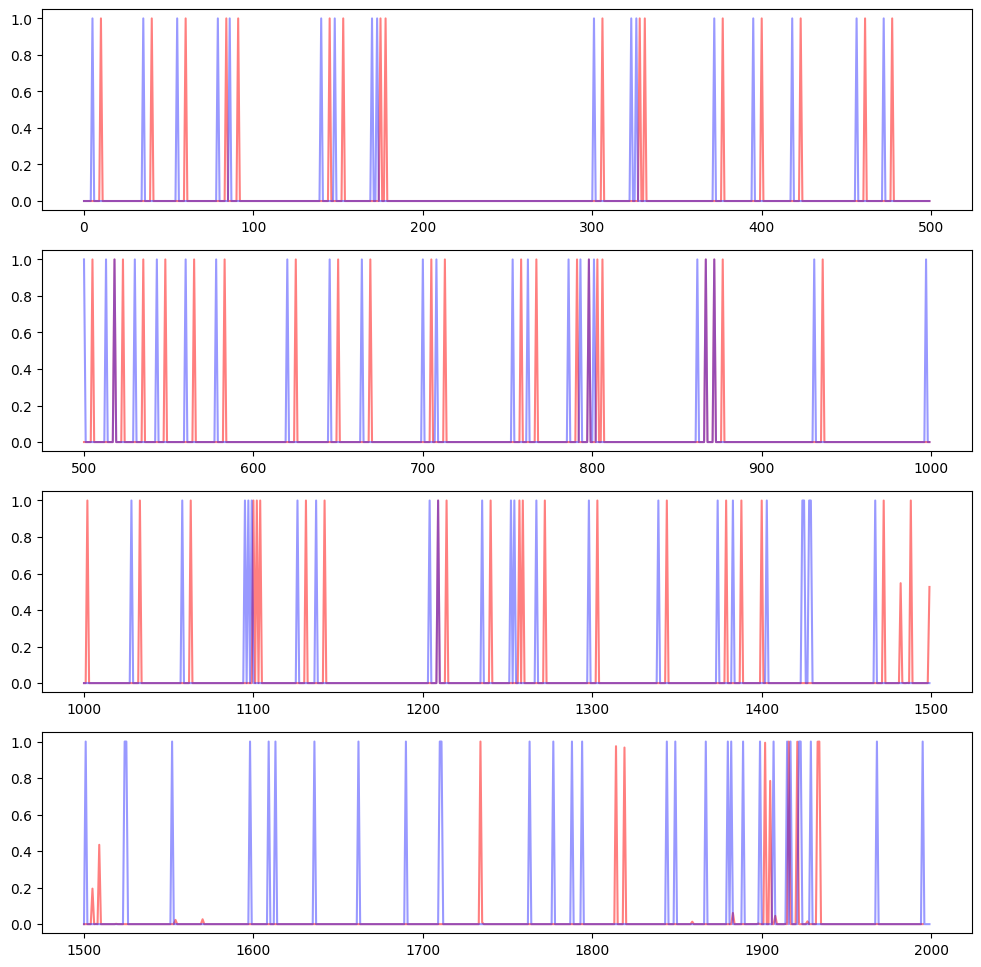

In [37]:
"""
plt.figure()
plt.plot(np.arange(train_result.shape[0]), train_result[:,2], c='red')
plt.plot(np.arange(target_train_df.shape[0]), target_train_df['states'], c='blue')
"""

print(changepoints)
print(np.where(np.round(all_pred_result[:,0]) >=1)[0] - WINDOW_WIDTH)
fig, axs = plt.subplots(T//500, 1, figsize=(12, 12))
for subplot_row in range(T//500):
    axs[subplot_row].plot(
        np.arange(min(1000, len(all_pred_result[:,0][subplot_row*500: subplot_row*500 + 500]))) + subplot_row*500,
        all_pred_result[:,0][subplot_row*500: subplot_row*500 + 500],
        c='red', alpha=0.5)
    axs[subplot_row].plot(
        np.arange(min(500, len(target_df['cps'][subplot_row*500: subplot_row*500 + 500]))) + subplot_row*500,
        target_df['cps'][subplot_row*500: subplot_row*500 + 500],
        c='blue', alpha=0.4)

[  42   71  324  693 1123 1419 1467 1485 1500 1597 1666 1791 1939 2000]
[  42   66   70   71  314  318  321  324  330  388  424  663  682  693
 1107 1110 1123 1126 1140 1146 1295 1301 1353 1383 1386 1643]


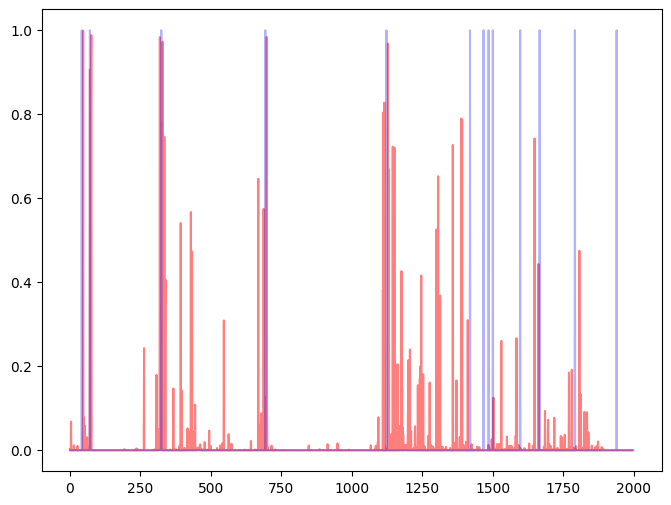

In [35]:
"""
plt.figure()
plt.plot(np.arange(train_result.shape[0]), train_result[:,2], c='red')
plt.plot(np.arange(target_train_df.shape[0]), target_train_df['states'], c='blue')
"""

print(changepoints)
print(np.where(np.round(all_pred_result[:,0]) >=1)[0] - WINDOW_WIDTH)
fig, axs = plt.subplots(T//1000, 1, figsize=(12, 12))
for subplot_row in range(T//1000):
    axs[subplot_row].plot(
        np.arange(min(1000, len(all_pred_result[:,0][subplot_row*1000: subplot_row*1000 + 1000]))) + subplot_row*1000,
        all_pred_result[:,0][subplot_row*1000: subplot_row*1000 + 1000],
        c='red', alpha=0.5)
    axs[subplot_row].plot(
        np.arange(min(1000, len(target_df['cps'][subplot_row*1000: subplot_row*1000 + 1000]))) + subplot_row*1000,
        target_df['cps'][subplot_row*1000: subplot_row*1000 + 1000],
        c='blue', alpha=0.4)

KeyError: 'lb_diff_coefs'

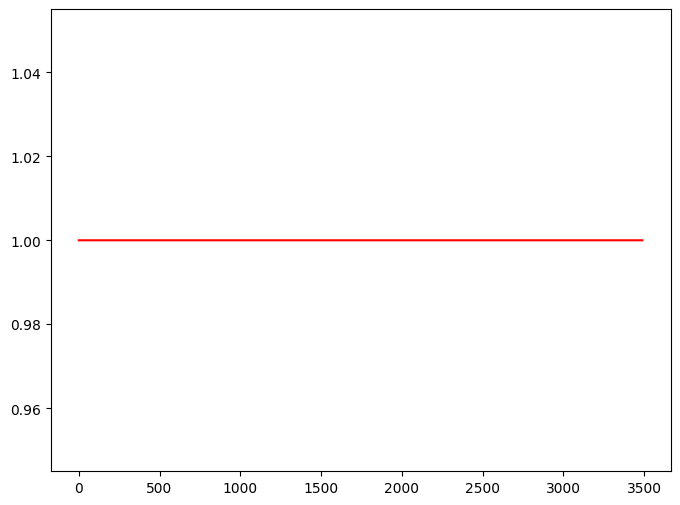

In [26]:
plt.figure()
plt.plot(np.arange(train_result.shape[0]), train_result[:,0], c='red')
plt.plot(np.arange(target_train_df.shape[0]), target_train_df['lb_diff_coefs'], c='blue')

plt.figure()
plt.plot(np.arange(train_result.shape[0]), train_result[:,1], c='red')
plt.plot(np.arange(target_train_df.shape[0]), target_train_df['alphas'], c='blue')

In [25]:
trajectory_object = trajectory_list[12]
trajectory_label = label_list[12]
msd = trajectory_object.get_msd(time_interval=TIME_INTERVAL)
diff_coefs = trajectory_object.get_diffusion_coefs(time_interval=TIME_INTERVAL)
angles = trajectory_object.get_trajectory_angles(time_interval=TIME_INTERVAL)

xs = trajectory_object.get_positions()[:,0]
ys = trajectory_object.get_positions()[:,1]
xs -= xs[0]
ys -= ys[0]

labeled_diff_coefs = trajectory_label[0]
labeled_alphas = trajectory_label[1]
labeled_states = trajectory_label[2]
labeled_cps = trajectory_label[3]

train_df = np.array([xs, ys, msd, diff_coefs, angles]).T
train_df = pd.DataFrame(train_df, columns=['xs', 'ys', 'msd', 'diff_coefs', 'angles'])
target_df = np.array([labeled_diff_coefs, labeled_alphas, labeled_states, labeled_cps]).T
target_df = pd.DataFrame(target_df, columns=['lb_diff_coefs', 'alphas', 'states', 'cps'])

test_ = make_prediction_set(train_df, WINDOW_WIDTH)
test_result = residual_lstm.predict(test_)

6/6 [==============================] - 1s 151ms/step


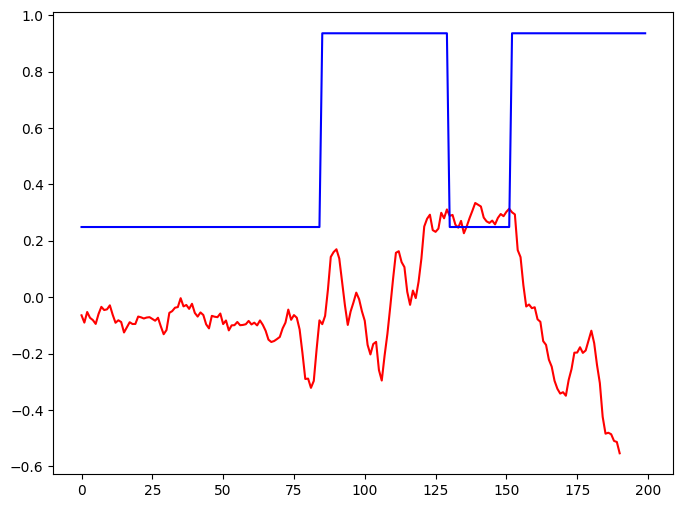

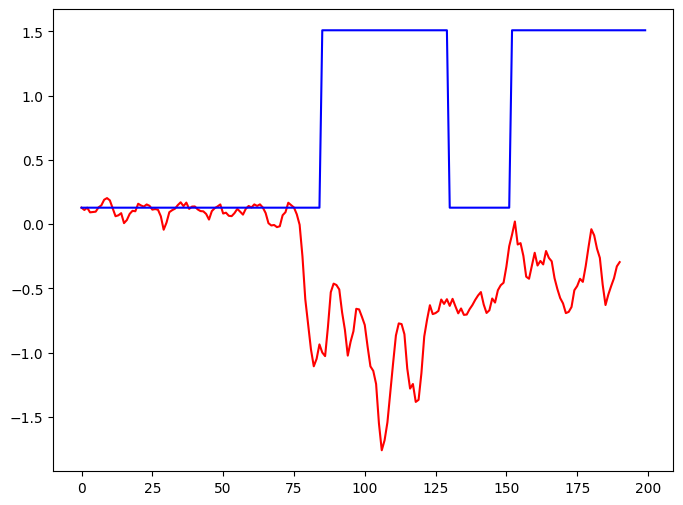

In [26]:
plt.figure()
plt.plot(np.arange(test_result.shape[0]), test_result[:,0], c='red')
plt.plot(np.arange(target_df.shape[0]), target_df['lb_diff_coefs'], c='blue')

plt.figure()
plt.plot(np.arange(test_result.shape[0]), test_result[:,1], c='red')
plt.plot(np.arange(target_df.shape[0]), target_df['alphas'], c='blue')